In [1]:
# import libraries

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# read dataset

df = pd.read_csv("/home/ankita/Desktop/Interpretable ML/Cervical Cancer Dataset/Cervical_Cancer_Dataset_Cleaned.csv", index_col=0)

df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Biopsy
0,18.0,4.0,15.0,1.0,True,0.0,True,0.0,True,0.0,True,0.0,0.0,1.0,1.0,0.0
1,15.0,1.0,14.0,1.0,True,0.0,True,0.0,True,0.0,True,0.0,0.0,1.0,1.0,0.0
2,34.0,1.0,15.0,1.0,True,0.0,True,0.0,True,0.0,True,0.0,0.0,1.0,1.0,0.0
3,52.0,5.0,16.0,4.0,False,37.0,False,3.0,True,0.0,True,0.0,0.0,1.0,1.0,0.0
4,46.0,3.0,21.0,4.0,True,0.0,False,15.0,True,0.0,True,0.0,0.0,1.0,1.0,0.0


In [3]:
df.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Biopsy'],
      dtype='object')

The necessary columns are only kept. 

In [4]:
df = df[["Hormonal Contraceptives", 'Smokes', 'Num of pregnancies', 'STDs: Number of diagnosis', 'IUD', 'Biopsy']].copy()

df.head()

,Hormonal Contraceptives,Smokes,Num of pregnancies,STDs: Number of diagnosis,IUD,Biopsy
0,True,True,1.0,0.0,True,0.0
1,True,True,1.0,0.0,True,0.0
2,True,True,1.0,0.0,True,0.0
3,False,False,4.0,0.0,True,0.0
4,False,True,4.0,0.0,True,0.0


In [5]:
train_cols = df.columns[0:-1]
label = df.columns[-1]

X = df[train_cols]
y = df[label]

In [6]:
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

# Interpret ML

In [7]:
from interpret import show
from interpret.data import ClassHistogram

hist = ClassHistogram().explain_data(X_train, y_train, name = 'Train Data')
show(hist)

<!-- http://127.0.0.1:7783/139717089197456/ -->

This is the case of an imbalanced classification. All the individual categorical features also show imbalance. 
The continuous feature 'Num of pregnancies' is positively skewed.

In [8]:
# one hot encoding

X_enc = pd.get_dummies(X)
feature_names = list(X_enc.columns)
X_train_enc, X_test_enc, y_train, y_test = train_test_split(X_enc, y, test_size=0.20, random_state=seed)

In [9]:
# fitting a logistics regression model

from interpret.glassbox import LogisticRegression

lr = LogisticRegression(random_state=seed, feature_names=feature_names)
lr.fit(X_train_enc, y_train)

In [10]:
lr.score(X_test_enc, y_test)

0.9302325581395349

The accuracy is 93%, but this needs further analysis as it was a case of imbalanced classification.

Hence, a precision recall curve is used instead of an ROC curve.

In [11]:
from interpret.perf import PR

In [12]:
lr_perf = PR(lr.predict_proba).explain_perf(X_test_enc, y_test, name='Logistic Regression')

show(lr_perf)

<!-- http://127.0.0.1:7783/139717032208784/ -->

The PR curve lies only slightly above the no-skill line, and this suggests that the classifier is not of much use. 

In [13]:
# global explanations

lr_global = lr.explain_global(name='LR')

show(lr_global)

<!-- http://127.0.0.1:7783/139717089500496/ -->

In [14]:
#local explanations

lr_local = lr.explain_local(X_test_enc[:5], y_test[:5], name='EBM')
show(lr_local)

<!-- http://127.0.0.1:7783/139716899381392/ -->

To find the odds ratio:

In [16]:
from math import exp


In [17]:
lr_data = lr_global.data()

In [18]:
# weights of the features in the classifier

lr_data

{'names': ['Hormonal Contraceptives',
  'Smokes',
  'Num of pregnancies',
  'STDs: Number of diagnosis',
  'IUD'],
 'scores': [0.11827940915157041,
  -0.37129306258238637,
  0.06418892646108126,
  1.0007091791762797,
  -0.5420537317180769],
 'extra': {'names': ['Intercept'], 'scores': [-2.241991644467928]}}

In [19]:
# odds ratio of the feature in the classifier

for i in range(0, 5):
    odd_r = exp(lr_data['scores'][i])
    feat_name = lr_data['names'][i]
    print(feat_name, odd_r)

Hormonal Contraceptives 1.125558558797508
Smokes 0.6898417451288669
Num of pregnancies 1.0662938308529157
STDs: Number of diagnosis 2.7202102610483423
IUD 0.5815526719254076


To further analyse the accuracy, the confusion matrix is plotted.

In [22]:
from sklearn.metrics import plot_confusion_matrix

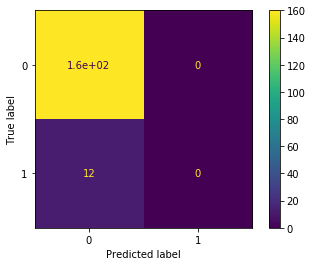

In [30]:
plot_confusion_matrix(lr, X_test_enc, y_test, display_labels=[0, 1])

In [24]:
y_test.value_counts()

0.0    160
1.0     12
Name: Biopsy, dtype: int64

This shows that the classifier has not been able to categorise between the two classes, and hence, in spite of the high accuracy value, it is of no use. 